# Classify the images for dogs
Load libs

In [87]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model # to convert out folders to catogeries

import cv2
import datetime
import timeit

# Helper function to load images

In [88]:
def load_images_from_folder(folder, image_size=(150, 150)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = Image.open(img_path)
                img = img.resize(image_size)
                img = np.array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load data

In [89]:
data_dir = './dataset_dogs/'
image_size = (150, 150)

### Load the images

In [90]:
X, y = load_images_from_folder(data_dir, image_size)

### Normalize pixel values to be between 0 and 1

In [91]:
X = X / 255.0

### Encode labels to integers

In [92]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Convert labels to one-hot encoding

In [93]:
y = to_categorical(y)
classes = len(label_encoder.classes_)
print("No. of classes = ", classes)

No. of classes =  10


# Split data into training and validation sets

In [94]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Convert the data into torch tensor

In [95]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Change to (batch, channels, height, width)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

_, y_train_class = torch.max(y_train_tensor, 1)
_, y_val_class = torch.max(y_val_tensor, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_class)
val_dataset = TensorDataset(X_val_tensor, y_val_class)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

# Print shapes to confirm
print(f'X_train shape: {X_train_tensor.shape}')
print(f'X_val shape: {X_val_tensor.shape}')
print(f'y_train shape: {y_train_tensor.shape}')
print(f'y_val shape: {y_val_tensor.shape}')

X_train shape: torch.Size([773, 3, 150, 150])
X_val shape: torch.Size([194, 3, 150, 150])
y_train shape: torch.Size([773, 10])
y_val shape: torch.Size([194, 10])


# Define the CNN model

In [96]:
class torch_dog_CNN(nn.Module):
    def __init__(self, classes):
        super(torch_dog_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 17 * 17, 512) # check tensor model summary
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, len(label_encoder.classes_) )
                             
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim = 1)
        return x


# Compile the model
model_torch = torch_dog_CNN(classes)

summary(model_torch, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
         MaxPool2d-2           [-1, 32, 74, 74]               0
            Conv2d-3           [-1, 64, 72, 72]          18,496
         MaxPool2d-4           [-1, 64, 36, 36]               0
            Conv2d-5          [-1, 128, 34, 34]          73,856
         MaxPool2d-6          [-1, 128, 17, 17]               0
           Flatten-7                [-1, 36992]               0
            Linear-8                  [-1, 512]      18,940,416
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 19,038,794
Trainable params: 19,038,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 11.55
Params size (MB): 72.63
Est

## Train the model

In [97]:
# Set up TensorBoard callback
log_dir = "logs/fit_torch/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir = log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Start the training

In [133]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    model.train()
    train_losses = []
    val_losses = []
    accuracy_torch = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)  
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracy_torch.append(accuracy)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)
        writer.add_scalar('Accuracy/validation', accuracy, epoch)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
        model.train()

    return train_losses, val_losses, accuracy_torch


train_losses, val_losses, accuracy_torch = train_model(model_torch, train_loader, val_loader, criterion, optimizer, num_epochs=100)

writer.close()

Epoch [1/100], Train Loss: 1.4674, Val Loss: 1.4964, Val Accuracy: 95.88%
Epoch [2/100], Train Loss: 1.4685, Val Loss: 1.4965, Val Accuracy: 95.88%
Epoch [3/100], Train Loss: 1.4675, Val Loss: 1.4968, Val Accuracy: 95.88%
Epoch [4/100], Train Loss: 1.4687, Val Loss: 1.4969, Val Accuracy: 95.88%
Epoch [5/100], Train Loss: 1.4771, Val Loss: 1.4965, Val Accuracy: 95.88%
Epoch [6/100], Train Loss: 1.4702, Val Loss: 1.4966, Val Accuracy: 95.88%
Epoch [7/100], Train Loss: 1.4711, Val Loss: 1.4967, Val Accuracy: 95.88%
Epoch [8/100], Train Loss: 1.4729, Val Loss: 1.4963, Val Accuracy: 95.88%
Epoch [9/100], Train Loss: 1.4686, Val Loss: 1.4968, Val Accuracy: 95.88%
Epoch [10/100], Train Loss: 1.4736, Val Loss: 1.4968, Val Accuracy: 95.88%
Epoch [11/100], Train Loss: 1.4686, Val Loss: 1.4968, Val Accuracy: 95.88%
Epoch [12/100], Train Loss: 1.4687, Val Loss: 1.4968, Val Accuracy: 95.88%
Epoch [13/100], Train Loss: 1.4686, Val Loss: 1.4968, Val Accuracy: 95.88%
Epoch [14/100], Train Loss: 1.4712

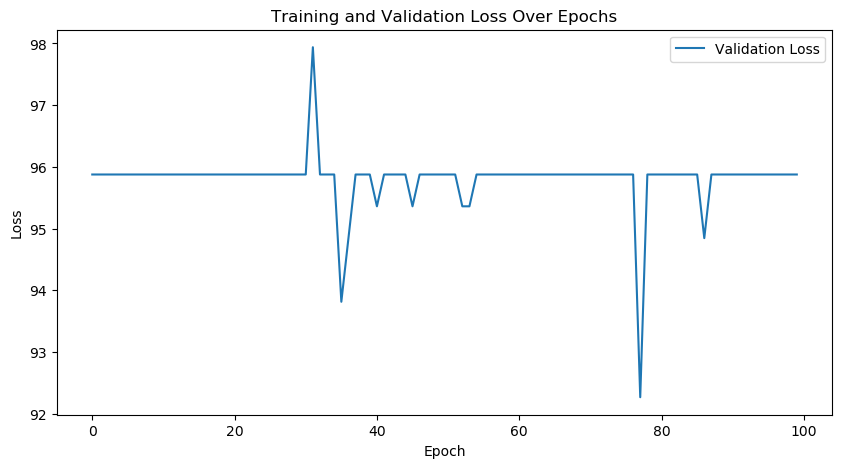

In [134]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
# plt.plot(accuracy_torch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Plot Losses

In [135]:
# Get training and validation loss from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(5.2, 5.2))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.yscale('log') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot as a PNG file
plt.savefig('training_validation_loss_torch_30epochs.png')

# Show plot
plt.show()

NameError: name 'history' is not defined

Start tesnorboard

In [ ]:
%tensorboard --logdir logs/fit

## Evaluate the model on the validation set

In [111]:
# Save the model state dictionary
torch.save(model_torch.state_dict(), 'dog_breed_classifier_model.pth')

# If you want to save the optimizer state as well
checkpoint = {
    'model_state_dict': model_torch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'dog_breed_classifier_checkpoint.pth')

# Predict breed of a random dog from the dataset

In [115]:
# Load the model state dictionary
model_torch_trained = torch_dog_CNN(classes)
model_torch_trained.load_state_dict(torch.load('dog_breed_classifier_model.pth'))
model_torch_trained.eval()  # Set the model to evaluation mode

# If you saved the optimizer state as well
checkpoint = torch.load('dog_breed_classifier_checkpoint.pth')
model_torch_trained.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model_torch_trained.eval()  # Set the model to evaluation mode

torch_dog_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=36992, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Prediction probabilities: tensor([[0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853]])


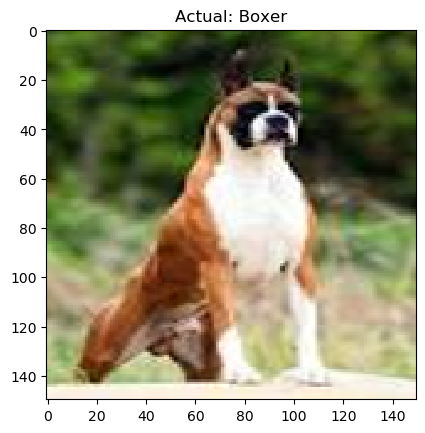

Predicted class: Boxer


In [128]:
def predict_random_image(model, X, y, label_encoder, save_dir, device):
    # Pick a random image from our dataset
    idx = random.randint(0, len(X) - 1)

    # img = X[idx].reshape(1, 150, 150, 3)
    img = torch.tensor(X[idx]).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Predict the class of the selected image
    model.eval()
    with torch.no_grad():
        y_pred = model(img)

    # Get the predicted class
    y_pred = torch.softmax(y_pred, dim=1)
    print(f'Prediction probabilities: {y_pred}')
    predicted_class = label_encoder.inverse_transform([torch.argmax(y_pred).item()])

    # y_pred = model.predict(X[idx].reshape(1, 150, 150, 3))
    # print(f'Prediction probabilities: {y_pred}')
    # predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    
    img = Image.fromarray((X[idx] * 255).astype(np.uint8))
    # Resize the image to the desired output size
    output_size = (500,500)
    img = img.resize(output_size, Image.ANTIALIAS)
    
    plt.imshow(X[idx])
    plt.title(f'Actual: {label_encoder.inverse_transform([np.argmax(y[idx])])[0]}')
    plt.show()
    
    # Draw the predicted class on the image
    draw = ImageDraw.Draw(img)
    font_size = 30
    font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
    font = ImageFont.truetype(font_path, font_size)
    text = f'Predicted: {predicted_class[0]}'
    textwidth, textheight = draw.textsize(text, font)
    width, height = img.size
    margin = 10
    x = width - textwidth - margin
    y = height - textheight - margin

    draw.text((x, y), text, font=font, fill=(255, 255, 255, 255))
    
    save_path = os.path.join(save_dir, f'predicted_{idx}_Orig.png')
    img.save(save_path)

    # Get the predicted class
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    print(f'Predicted class: {predicted_class[0]}')

# Load the trained model
model_torch_trained = torch_dog_CNN(classes)
model_torch_trained.load_state_dict(torch.load('dog_breed_classifier_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_torch_trained.to(device)

pred_dir = './zzz_my_predictions/'

# Predict for a random image
predict_random_image(model_torch_trained, X_val, y_val, label_encoder, pred_dir, device)

## Here I test actual pictures of my dog and see if my model identifies it
She is labrador btw ;)

In [130]:
test_dir = './Test/'

# Check the input shape of the model
# input_shape = model.layers[0].input_shape
img_height, img_width = 150, 150#input_shape[1], input_shape[2]
target_image_size=(img_height, img_width)

# Iterate through the images in the test directory and process them
test_images = []
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    img = Image.open(img_path)
    img = img.resize(target_image_size)
    img = np.array(img)
    img = img / 255.0 # Normalize the image array
    test_images.append(img)

len(test_images)

18

## Make predictions for my dog 

In [132]:
def predict_my_test_image(model, X, label_encoder, idx, save_dir, training_images):
    os.makedirs(save_dir, exist_ok=True)

    # img = X[idx].reshape(1, 150, 150, 3)
    img = torch.tensor(X[idx]).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    # Predict the class of the selected image
    model.eval()
    with torch.no_grad():
        y_pred = model(img)

    # Get the predicted class
    y_pred = torch.softmax(y_pred, dim=1)
    print(f'Prediction probabilities: {y_pred}')
    predicted_class = label_encoder.inverse_transform([torch.argmax(y_pred).item()])

    # Get the predicted class
    predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    print(f'Predicted class: {predicted_class[0]}')

    # y_pred = model.predict(X[idx].reshape(1, 150, 150, 3))
    # print(f'Prediction probabilities: {y_pred}')
    # predicted_class = label_encoder.inverse_transform([np.argmax(y_pred)])
    
    img = Image.fromarray((X[idx] * 255).astype(np.uint8))
    # Resize the image to the desired output size
    output_size = (500,500)
    img = img.resize(output_size, Image.ANTIALIAS)
    
    # plt.imshow(X[idx])
    # # plt.title(f'Actual: {label_encoder.inverse_transform([np.argmax(y[idx])])[0]}')
    # plt.show()
    
    # Draw the predicted class on the image
    draw = ImageDraw.Draw(img)
    font_size = 30
    font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
    font = ImageFont.truetype(font_path, font_size)
    text = f'Predicted: {predicted_class[0]}'
    textwidth, textheight = draw.textsize(text, font)
    width, height = img.size
    margin = 10
    x = width - textwidth - margin
    y = height - textheight - margin

    draw.text((x, y), text, font=font, fill=(255, 255, 255, 255))
    
    save_path = os.path.join(save_dir, f'predicted_{idx}_Orig.png')
    img.save(save_path)

# Predict for a random image
for img_id in range(len(test_images)):
    predict_my_test_image(model_torch_trained, test_images, label_encoder, img_id, pred_dir, X)

Prediction probabilities: tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853]])
Predicted class: German_Shepherd
Prediction probabilities: tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853,
         0.0853]])
Predicted class: Poodle
Prediction probabilities: tensor([[0.0853, 0.2318, 0.0853, 0.0853, 0.0854, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853]])
Predicted class: Boxer
Prediction probabilities: tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.2320]])
Predicted class: Yorkshire_Terrier
Prediction probabilities: tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853,
         0.0853]])
Predicted class: Labrador_Retriever
Prediction probabilities: tensor([[0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
         0.0853]])
Predicted class: Beagle
Prediction probabilities: tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.

## Plot Losses